In [1]:
# imports
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Marvin\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\Marvin\anaconda3\lib\site-packages\pypsa\networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



# Import der Basisdaten

### HIER MÜSSEN WIR NOCH EINMAL FESTHALTEN WOHER UNSERE DATEN KOMMEN UND DAS SAUBER AUFLISTEN

### PV-Daten: Renewables.Ninja
Basierend auf Europäischem Datenset:CM-SAF SARAH (Europe) hohe Genauigkeit, da Angabe aus (lon/lat) -> VLH = 1072

### Temperaturdaten: DWD open database
Basierend auf historischen Daten für das Jahr 2022 der Wetterstation am Flughafen Köln/Bonn (ca. 12km Luftlinie)
-> Kälteanomalie im Dezember: kurzzeitig Temperaturen bis -10-Grad

### Preisdaten: SMARD
Großhandels Strompreis auf die kWh-heruntergerechnet als Beispiel für einen Strompreis von z.B. dem Anbieter Tibber, welcher den Großhandelspreis an den Kunden stündlich weitergibt

In [2]:
# data imports
df_data = pd.read_csv("data/Modellierung_SoSe23.csv", sep=";", decimal=",", usecols=[0,1,4])

# load pv_data
pv_data = pd.read_csv("data/ninja_pv_50.8263_6.9721.csv", decimal=".", header=3)

# load and prepare temp data
temp_data = pd.read_csv("data/DWD_wetterdaten_KoelnBonn_Flughafen.txt", sep=";", decimal=".", usecols=[1,3])
temp_data = temp_data[(temp_data['MESS_DATUM'] >= 2022010100) & (temp_data['MESS_DATUM'] < 2023010101)]

# load electricity price data
df_price_data = pd.read_csv("data/Strompreise2019_2022.csv", sep=";", decimal=".", usecols=[2,3,4])
df_price_data["2020_neg"] = df_price_data["2020"].apply(lambda x: 1 if x < 0 else 0)
df_price_data["2020_pos"] = 1 - df_price_data["2020_neg"]
df_price_data["2021_neg"] = df_price_data["2021"].apply(lambda x: 1 if x < 0 else 0)
df_price_data["2021_pos"] = 1 - df_price_data["2021_neg"]
df_price_data["2022_neg"] = df_price_data["2022"].apply(lambda x: 1 if x < 0 else 0)
df_price_data["2022_pos"] = 1 - df_price_data["2022_neg"]



# fill dataframe
df_data['pv'] = pv_data['electricity'].to_numpy()
df_data['temp'] = temp_data['TT_TU'].to_numpy()

# season operation of hydrogen system (If PV-power is higher than 0.6 then use ely otherwise use fc)
df_season = pd.DataFrame()
df_season['fc'] = df_data['pv'].apply(lambda x: 1 if x >= 0.6 else 0)
df_season['ely'] = 1 - df_season['fc']

df_data

,Zeit,electric_load,heat_load,pv,temp
0,01.01. 00:00,0.016247,0.22,0.0,12.6
1,01.01. 01:00,0.016162,0.13,0.0,13.0
2,01.01. 02:00,0.016005,0.07,0.0,12.6
3,01.01. 03:00,0.166450,0.03,0.0,12.2
4,01.01. 04:00,0.016200,0.07,0.0,12.8
...,...,...,...,...,...
8755,31.12. 19:00,1.107500,1.69,0.0,15.1
8756,31.12. 20:00,0.261240,1.73,0.0,15.9
8757,31.12. 21:00,0.289830,1.33,0.0,15.9
8758,31.12. 22:00,0.340810,0.81,0.0,15.6


In [3]:
# calculation and data preparation for heat_pump(wp)

# scraped data
wp_data = {
    "temp" : [-22, -15, -7, 2, 7, 10, 12, 20, 25, 30, 35],
    "heating_power" : [0, 25.50, 35.20, 43.00, 56.40, 60.30, 62.90, 67.30, 70.40, 73.60, 76.70],
    "el_power" : [0, 14.58, 15.54, 16.70, 18.54, 18.87, 18.87, 19.05, 19.13, 19.36, 19.46],
    "cop" : [0, 1.7, 2.3, 2.6, 3.0, 3.2, 3.3, 3.5, 3.7, 3.8, 3.9]
}

# assumptions
wp_el_p_nom = 12.5  # kW

# calculate COP
df_data["wp_COP_interp"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["cop"]),3)
df_data["wp_power_consumption"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["el_power"]),2)
df_data['wp_power_cons_norm'] = df_data["wp_power_consumption"] / wp_el_p_nom

df_data

,Zeit,electric_load,heat_load,pv,temp,wp_COP_interp,wp_power_consumption,wp_power_cons_norm
0,01.01. 00:00,0.016247,0.22,0.0,12.6,3.315,18.88,1.5104
1,01.01. 01:00,0.016162,0.13,0.0,13.0,3.325,18.89,1.5112
2,01.01. 02:00,0.016005,0.07,0.0,12.6,3.315,18.88,1.5104
3,01.01. 03:00,0.166450,0.03,0.0,12.2,3.305,18.87,1.5096
4,01.01. 04:00,0.016200,0.07,0.0,12.8,3.320,18.89,1.5112
...,...,...,...,...,...,...,...,...
8755,31.12. 19:00,1.107500,1.69,0.0,15.1,3.378,18.94,1.5152
8756,31.12. 20:00,0.261240,1.73,0.0,15.9,3.398,18.96,1.5168
8757,31.12. 21:00,0.289830,1.33,0.0,15.9,3.398,18.96,1.5168
8758,31.12. 22:00,0.340810,0.81,0.0,15.6,3.390,18.95,1.5160


# Parameter- und Variablendefinition

### Komponentenparameter
Für eine leichtere Lesbarkeit und einfachere Zuordnung aller festgelegten Basisparameter, werden Basisdaten in Dictionarys mit eindeutigen Keys definiert

### Basisvariablen 
Generelle Basisvariablen wie z.B. der Strompreis oder die Gebäudedefinition werden in einfachen globalen Variablen gespeichert

In [4]:
# basicvariables
# cost related variables
electricity_rate = 0.4 # €/kWh
infeed_rate = -0.078    # €/kWh
gas_price = 0.158

# building related variables
living_space = 157 #m²

# grid parameters


# data calculations 
# -> here <-------------------!


# component parameters
# PV-plant
pv_params = {
    'p_nom': 10,    # kWp
    'p_max_pu': df_data['pv'],
    'capital_cost': 650,
    'marginal_cost': 0,
    'lifespan' : 20,
    'pv_co2': 0   #kg/kWh
}

# FuelCell -> fc
fc_params = {
    'p_nom': 1.5, #kW_el Brennstoffzellenleistung picea
    'el_efficiency': 0.8,
    'th_efficiency': 0.2,
    'capital_cost': 400,
    'marginal_cost': 0
}

# Electrolyser -> ely
ely_params = {
    'p_nom': 2.3, #kW_el Wasserstofferzeugungsleistung picea
    'el_efficiency': 0.625,
    'th_efficiency': 0.2,
    'capital_cost': 400,
    'marginal_cost': 0
}

# heatpump -> wp
wp_params = {
    'p_nom': 12.5,
    'efficiency': df_data['wp_COP_interp'],
    'capital_cost': 1250,
    'marginal_cost': 50
}

# battery storage
battery_params = { # battery integrated in picea system
    'e_nom': 20, #kWh picea system
    'e_nom_min': 20,
    #'e_max_pu': 1.0,
    'capital_cost': 550,
    'marginal_cost': 0,
    'standing_loss': 0.0001,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
    'charge_power': 5.7,
    'discharge_power': 5.7,
}

# heat storage
heat_storage_params = {
    'e_nom': 25, #kWh
    'e_min_pu': 0.6,
    'e_max_pu': 1.0,
    'e_nom_min': 5,
    'volume': 300, #Litre
    'capital_cost': 80,
    'marginal_cost': 1.25,
    'standing_loss': 0.08,
    'charge_efficiency': 0.95,
    'discharge_efficiency': 0.95,
}

# H2 gas storage
h2_storage_params = {
    'e_nom': 1500, #kWh_el - picea, auf 1500 kWh_el erweiterbar
    'e_nom_min' : 300,
    #'e_min_pu_hydrogen': 0.6,
    #'e_max_pu_hydrogen': 1.0,
    'capital_cost': 400, # € picea system
    'marginal_cost': 0, # Kosten Wasser
    'standing_loss': 0.00001,
    'h2_co2': 0   #kg/kWh
}

#CO2 emissions
co2_params = {
    'co2_emissions_germany_electricity': 0.434 #kg/kWh
}

# Funktionsdefinitionen

### Aufbau des Referenznetzwerks
### Aufbau des Wasserstoff Netzwerkes
### Auswertung

In [5]:
def build_ref_network():

    # initialyze network
    n_ref = pypsa.Network()
    n_ref.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_ref.add('Carrier', name = 'grid_electricity',
              co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_ref.add('Carrier', name = 'pv_electricity', 
              co2_emissions = pv_params['pv_co2'])
    
    # Buses 
    # electrical buses
    n_ref.add('Bus', name='electricity')
    n_ref.add('Bus', name='bat_bus')    
    # heat buses
    n_ref.add('Bus', name='heat')
    n_ref.add('Bus', name='heat_storage_bus')


    # Loads
    # electrical
    n_ref.add('Load', name='electric_load', bus='electricity',
              p_set = df_data['electric_load'])
    # heat
    n_ref.add('Load', name='heat_load', bus='heat', 
              p_set = df_data['heat_load'])

    # Generators
    # PV
    n_ref.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'], 
              carrier='pv_electricity')
    # grid  
    n_ref.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_ref.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate, 
              carrier = 'grid_electricity',
              p_nom_extendable = True)


    # Storages
    '''
    n_ref.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'], 
              standing_loss = battery_params['standing_loss'], 
              e_nom_min = battery_params['e_nom_min'],
              e_nom_extendable = True,
              e_cyclic = True)'''
    n_ref.add('Store', name= 'heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_nom_min = heat_storage_params['e_nom_min'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    '''
    n_ref.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_params['charge_power'],
              efficiency = battery_params['charge_efficiency'])
    n_ref.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_params['discharge_power'],
              efficiency = battery_params['discharge_efficiency'])
              '''
    n_ref.add('Link', name='wp', bus0='electricity', bus1='heat',
              efficiency = wp_params['efficiency'],
              capital_cost= wp_params['capital_cost'],
              p_nom_extendable = True) #wp_params['p_nom'])
    n_ref.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = wp_params["p_nom"])
    n_ref.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = wp_params["p_nom"])
    
    # Global Constraints
    n_ref.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
              carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_ref

In [6]:
#n_ref = build_ref_network()

#n_ref.optimize(solver_name='gurobi')
#n_ref.generators

In [7]:
def build_h2_network():
    
    # setup Multilinks
    
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    
    # initialyze network
    n_h2 = pypsa.Network(override_component_attrs=override_component_attrs)
    #n_h2 = pypsa.Network()
    n_h2.set_snapshots(range(8760))

    # add components
    
    # Carrier
    
    n_h2.add('Carrier', name = 'grid_electricity', 
                co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_h2.add('Carrier', name = 'pv_electricity', 
             co2_emissions = pv_params['pv_co2'])
    n_h2.add('Carrier', name = 'h2_electricity', 
             co2_emissions = h2_storage_params['h2_co2'])
    # Buses 
    # electrical buses
    n_h2.add('Bus', name='electricity')
    n_h2.add('Bus', name='bat_bus')    
    #n_h2.add('Bus', name='house_IO')   # Überschussknoten -> Haus In- und Output
    # heat buses
    n_h2.add('Bus', name='heat')
    n_h2.add('Bus', name='heat_storage_bus')
    # gas bus
    n_h2.add('Bus', name='h2_bus', carrier='h2_electricity')

    # Loads
    # electrical
    n_h2.add('Load', name='electric_load', bus='electricity',
              p_set = df_data['electric_load'])
    # heat
    n_h2.add('Load', name='heat_load', bus='heat', p_set = df_data['heat_load'])

    # Generators
    # PV
    n_h2.add('Generator', name='pv', bus='electricity',
             p_nom = pv_params['p_nom'],
             p_max_pu = pv_params['p_max_pu'],
             capital_cost = pv_params['capital_cost'],
             marginal_cost = -0.10, # pv_params['marginal_cost'], 
             carrier='pv_electricity')
    # grid
    n_h2.add('Generator', name='infeed', bus='electricity',
             marginal_cost = np.inf,
             sign = -1, 
             p_nom_extendable = True)
    n_h2.add('Generator', name='grid', bus='electricity', 
             marginal_cost = electricity_rate,
             p_nom_extendable = True,
             carrier = 'grid_electricity')


    # Storages
    n_h2.add('Store', name='battery',  bus='bat_bus',
             capital_cost = battery_params['capital_cost'], 
             standing_loss = battery_params['standing_loss'],
             e_nom = battery_params['e_nom'],
             e_cyclic = True)
    
    n_h2.add('Store', name= 'heat_storage', bus='heat_storage_bus',
             e_nom = heat_storage_params['e_nom'],
             capital_cost = heat_storage_params['capital_cost'],
             standing_loss = heat_storage_params['standing_loss'],
             e_cyclic = True)
    n_h2.add('Store', name='h2_storage', bus='h2_bus',
             capital_cost = h2_storage_params['capital_cost'],
             standing_loss = h2_storage_params['standing_loss'],
             e_nom_min = h2_storage_params['e_nom_min'],
             e_nom_extendable = True,
             e_cyclic = True)


    # Links
    n_h2.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_params['charge_power'],
              efficiency = battery_params['charge_efficiency'])
    n_h2.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_params['discharge_power'],
              efficiency = battery_params['discharge_efficiency'])
    #n_h2.add('Link', name='housegrid_in', bus0='house_IO', bus1='electricity', 
              #p_nom_extendable = True)
    
    n_h2.add('Link', name='wp', bus0='electricity', bus1='heat',
              efficiency = wp_params['efficiency'],
              capital_cost= wp_params['capital_cost'],
              p_nom = wp_params['p_nom'])
    
    n_h2.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = wp_params["p_nom"])
    n_h2.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = wp_params["p_nom"])

    
    # Multilinks
    # electrolysis
    n_h2.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
             efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
             capital_cost = ely_params['capital_cost'],
             marginal_cost = -0.05,
             p_nom = ely_params['p_nom'],
             carrier='h2_electricity')
    # fuellcell
    n_h2.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
             efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
             capital_cost = fc_params['capital_cost'],
             marginal_cost = 0,
             p_nom = fc_params['p_nom'],
             carrier='h2_electricity')
    '''
    
    # electrolysis
    n_h2.add('Link', name='ely1', bus0='electricity', bus1='h2_bus',
             efficiency = ely_params['el_efficiency'],
             capital_cost = ely_params['capital_cost'],
             p_nom_extendable = True,
             carrier = 'h2_electricity')
    
    n_h2.add('Link', name='ely2', bus0='electricity', bus1='heat',
             efficiency = ely_params['th_efficiency'],
             capital_cost = ely_params['capital_cost'],
             p_nom_extendable = True,
             carrier = 'h2_electricity')
    
    # fuellcell
    n_h2.add('Link', name='fc1', bus0='h2_bus', bus1='electricity',
             efficiency = fc_params['el_efficiency'],
             capital_cost = fc_params['capital_cost'],
             p_nom_extendable = True,
             carrier = 'h2_electricity')
    
    n_h2.add('Link', name='fc2', bus0='h2_bus', bus1='heat',
             efficiency = fc_params['th_efficiency'],
             capital_cost = fc_params['capital_cost'],
             p_nom_extendable = True,
             carrier = 'h2_electricity')
    '''
    
    # Global Constraints
    n_h2.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
            carrier_attribute = 'co2_emissions', constant = np.inf)
    return n_h2

In [8]:
#n_h2 = build_h2_network()

#n_h2.optimize(solver_name='gurobi')

In [9]:
def auswertungsfunktion(network, sensitivity_variable=0, co2_constraint=0):
    #Funktion der laufenden kosten
    if network == n_h2:
        
        #co2 Calculation
        co2 = (network.generators_t.p.sum() / network.generators.efficiency * 
               pd.merge(network.carriers, network.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
        
        #Funktion der laufende Kosten
        laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost.grid).sum()
        #Funktion für Investitionskosten
        #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
        kapital_kosten_generators = (network.generators.p_nom_opt.pv * network.generators.capital_cost.pv).sum()
        kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
        kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
        kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

        #Gesamtkosten pro Jahr
        total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
        + kapital_kosten_stores + kapital_kosten_links) 


        #Einspeisevergütung (separat betrachtet von Gesamtkosten)
        einspeise_ertrag = 0


        #Jährliche Einsparung der marginalen Kosten
        bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                          network.loads_t.p.heat_load * gas_price).sum()
        einsparung = bezug_ursprung - laufende_kosten_generators 

        #Armotisation
        Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
        Amortisation = Anschaffungskosten/einsparung 


        #relevante Ausgabewerte
        netzbezug_summe = (network.generators_t.p.grid).sum()
        netzeinspeisung_summe= 0
        pv_ertrag_summe = (network.generators_t.p.pv).sum()
        einspeicherung_summe = (network.links_t.p0.charge_bat).sum()
        ausspeicherung_summe = (network.links_t.p0.discharge_bat).sum()
        Kapazität_Batterie = (network.stores.e_nom_opt.battery)
        Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
        Leistung_wp = (network.links.p_nom_opt.wp)



        #Werte in Ergebnistabelle auflisten
        df_result = pd.concat([pd.DataFrame(data=co2, index=[sensitivity_variable], columns=['CO2_emissions in kg/a']),
                               pd.DataFrame(data=total_kosten, index=[sensitivity_variable], columns=['Kapital- und marginale kosten €/a']),
                               pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                               pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                               pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                               pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                               pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                               pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                               pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                               pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                               pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                               pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                               pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                               pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                               pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                               pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                               axis = 1)
    else:
       
        #co2 Calculation
        co2 = (network.generators_t.p.sum() / network.generators.efficiency * 
               pd.merge(network.carriers, network.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
       
        #Funktion der laufende Kosten 
        laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost.grid + 
                                      network.generators_t.p.infeed * network.generators.marginal_cost.infeed).sum()
        
        #Funktion für Investitionskosten
        #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
        kapital_kosten_generators = (network.generators.p_nom_opt.pv * network.generators.capital_cost.pv).sum()
        kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
        kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
        kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

        #Gesamtkosten pro Jahr
        total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
        + kapital_kosten_stores + kapital_kosten_links) 


        #Einspeisevergütung (separat betrachtet von Gesamtkosten)
        einspeise_ertrag = (network.generators_t.p.infeed).sum()*electricity_rate *-1


        #Jährliche Einsparung der marginalen Kosten
        bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                          network.loads_t.p.heat_load * gas_price).sum()
        einsparung = bezug_ursprung - laufende_kosten_generators 

        #Armotisation
        Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
        Amortisation = Anschaffungskosten/einsparung 


        #relevante Ausgabewerte
        netzbezug_summe = (network.generators_t.p.grid).sum()
        netzeinspeisung_summe= (network.generators_t.p.infeed).sum()
        pv_ertrag_summe = (network.generators_t.p.pv).sum()
        einspeicherung_summe = (network.links_t.p0.charge_bat).sum()
        ausspeicherung_summe = (network.links_t.p0.discharge_bat).sum()
        Kapazität_Batterie = (network.stores.e_nom_opt.battery)
        Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
        Leistung_wp = (network.links.p_nom_opt.wp)



        #Werte in Ergebnistabelle auflisten
        df_result = pd.concat([pd.DataFrame(data=co2, index=[sensitivity_variable], columns=['CO2_emissions in kg/a']),
                               pd.DataFrame(data=total_kosten, index=[sensitivity_variable],columns=['Kapital- und marginale kosten €/a']),
                               pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                               pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                               pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                               pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                               pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                               pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                               pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                               pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                               pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                               pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                               pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                               pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                               pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                               pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                               axis = 1)

    return df_result

In [10]:
def opt_series_summary(network, h2=False):

    date_index = pd.date_range(start='2022-01-01 00:00', end='2022-12-31 23:00', freq='H')
    
    co2 = (network.generators_t.p.sum() / network.generators.efficiency * 
               pd.merge(network.carriers, network.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
    print("CO2-Emissionen: ", co2)
    
    if h2 == True:
        try:
            df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage']),
                                       pd.DataFrame(data=network.stores_t.e.h2_storage.to_numpy(), index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), index=date_index, columns=['WP']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']),
                                       pd.DataFrame(data=network.links_t.p0.fc1.to_numpy(), index=date_index, columns=['Fuel Cell1']),
                                       pd.DataFrame(data=network.links_t.p0.ely1.to_numpy(), index=date_index, columns=['Electrolysis1']),
                                       pd.DataFrame(data=network.links_t.p0.fc2.to_numpy(), index=date_index, columns=['Fuel Cell2']),
                                       pd.DataFrame(data=network.links_t.p0.ely2.to_numpy(), index=date_index, columns=['Electrolysis2'])],
                                       axis = 1)
        except:
            try:
                df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                           pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                           pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), index=date_index, columns=['Einspeisung']), 
                                           pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), index=date_index, columns=['Battery']),
                                           pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage']),
                                           pd.DataFrame(data=network.stores_t.e.h2_storage.to_numpy(), index=date_index, columns=['H2 Storage']),
                                           pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), index=date_index, columns=['WP']),
                                           pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                           pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                           pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                           pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']),
                                           pd.DataFrame(data=network.links_t.p0.fc.to_numpy(), index=date_index, columns=['Fuel Cell']),
                                           pd.DataFrame(data=network.links_t.p0.ely.to_numpy(), index=date_index, columns=['Electrolysis'])],
                                           axis = 1)
            except:
                df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                           pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']), 
                                           pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), index=date_index, columns=['Battery']),
                                           pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage']),
                                           pd.DataFrame(data=network.stores_t.e.h2_storage.to_numpy(), index=date_index, columns=['H2 Storage']),
                                           pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), index=date_index, columns=['WP']),
                                           pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                           pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                           pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                           pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']),
                                           pd.DataFrame(data=network.links_t.p0.fc.to_numpy(), index=date_index, columns=['Fuel Cell']),
                                           pd.DataFrame(data=network.links_t.p0.ely.to_numpy(), index=date_index, columns=['Electrolysis'])],
                                           axis = 1)
    else:
        try:
            df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']),
                                       pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), index=date_index, columns=['WP'])],
                                       axis = 1)
        except:
            df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']),
                                   pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), index=date_index, columns=['WP'])],
                                   axis = 1)
    
    return df_res_series

In [11]:
def calc_global_results(n1, n2):
    
    # calculate result information
    
    
    return df_global_results

In [12]:
def plot_series_data(series):
    fig, axes = plt.subplots(4, 4, figsize=(16, 10))

    for col, ax in zip(series.columns, axes.flatten()):
        ax.plot(series.index, series[col])
        ax.set_title(col)
        plt.subplots_adjust(wspace=.5, hspace=.5) 

In [13]:
# Standard szenario - ohne Preisprofil - optimierung Speicher im Referenz Netzwerk und Festlegung im H2 netzwerk
n_ref = build_ref_network()
n_ref.optimize(solver_name='gurobi')

co2_ref = (n_ref.generators_t.p.sum() / n_ref.generators.efficiency * 
           pd.merge(n_ref.carriers, n_ref.generators.carrier, 
                    left_index = True, 
                    right_on = 'carrier')['co2_emissions']).sum()
#print("batterie: ", n_ref.stores.e_nom_opt.battery, "\nheat storage: ", n_ref.stores.e_nom_opt.heat_storage)

n_h2 = build_h2_network()
#n_h2.stores.e_nom.battery = n_ref.stores.e_nom_opt.battery
n_h2.stores.e_nom.heat_storage = n_ref.stores.e_nom_opt.heat_storage
n_h2.links.p_nom.wp = n_ref.links.p_nom_opt.wp
n_h2.links.p_nom_max.charge_heat = n_ref.links.p_nom_opt.wp
n_h2.links.p_nom_max.discharge_heat = n_ref.links.p_nom_opt.wp
n_h2.global_constraints.loc['co2-limit', 'constant'] = co2_ref * 0.5
n_h2.optimize(solver_name='gurobi')

ref_series = opt_series_summary(n_ref)
h2_series = opt_series_summary(n_h2, h2=True)

{'bat_bus'}
{'bat_bus'}
INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 48.72it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-18


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-fgod4mh5.lp
Reading time = 0.24 seconds
obj: 157689 rows, 70086 columns, 297848 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 157689 rows, 70086 columns and 297848 nonzeros
Model fingerprint: 0x9fb7bb68
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [8e-02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120032 rows and 29810 columns
Presolve time: 0.10s
Presolved: 37657 rows, 40276 columns, 104211 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

B

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70086 primals, 157689 duals
Objective: 4.66e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_27344\725518888.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Marvin\AppData\Local\Temp\ipykernel_27344\725518888.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Marvin\AppData\Local\Temp\ipykernel_27344\725518888.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-8uxjkor1.lp
Reading time = 0.47 seconds
obj: 297848 rows, 140165 columns, 551887 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297848 rows, 140165 columns and 551887 nonzeros
Model fingerprint: 0x445d0fd5
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [5e-02, 1e+100]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 9e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245665 rows and 31081 columns
Presolve time: 0.19s
Presolved: 52183 rows, 109084 columns, 239349 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140165 primals, 297848 duals
Objective: 1.19e+05
Solver model: available
Solver message: 2



CO2-Emissionen:  1714.0851751551343
CO2-Emissionen:  604.8725636145017


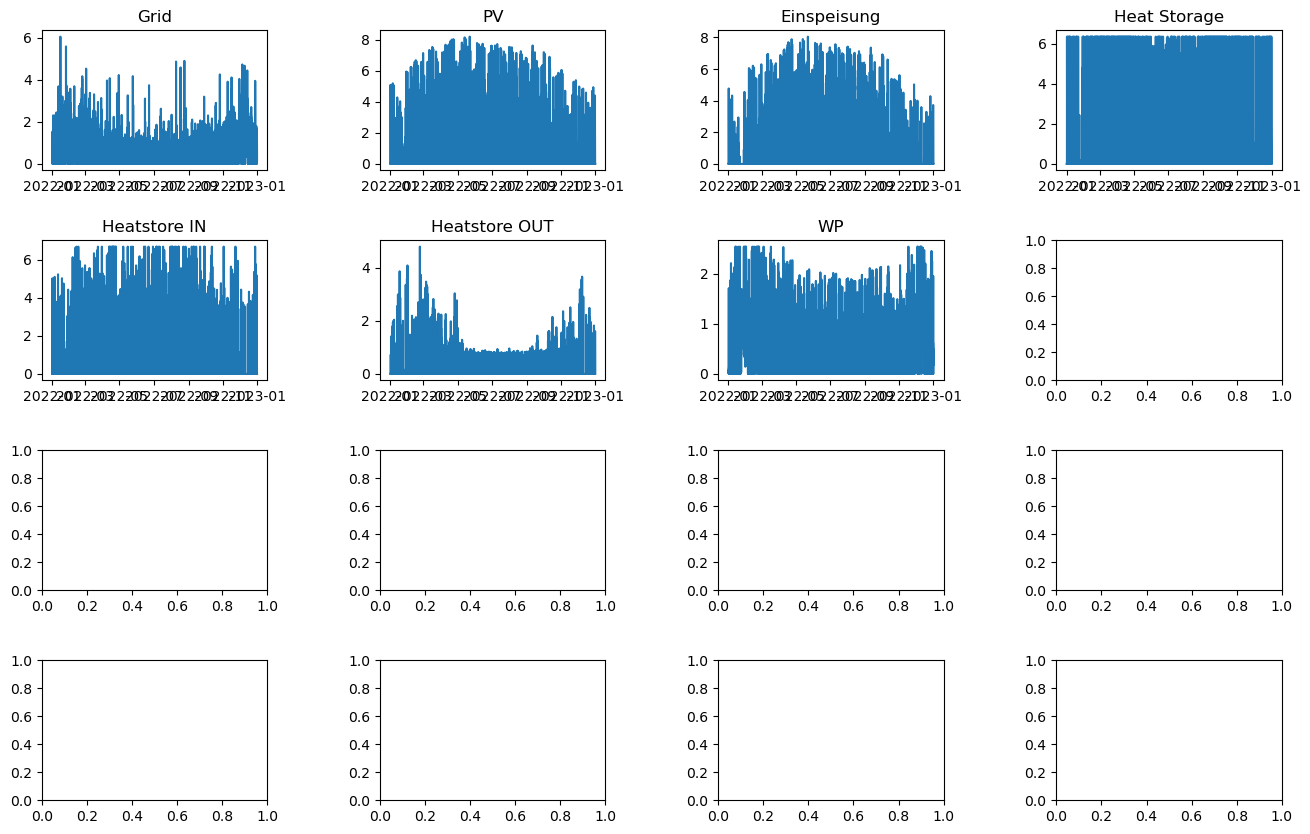

In [14]:
plot_series_data(ref_series)

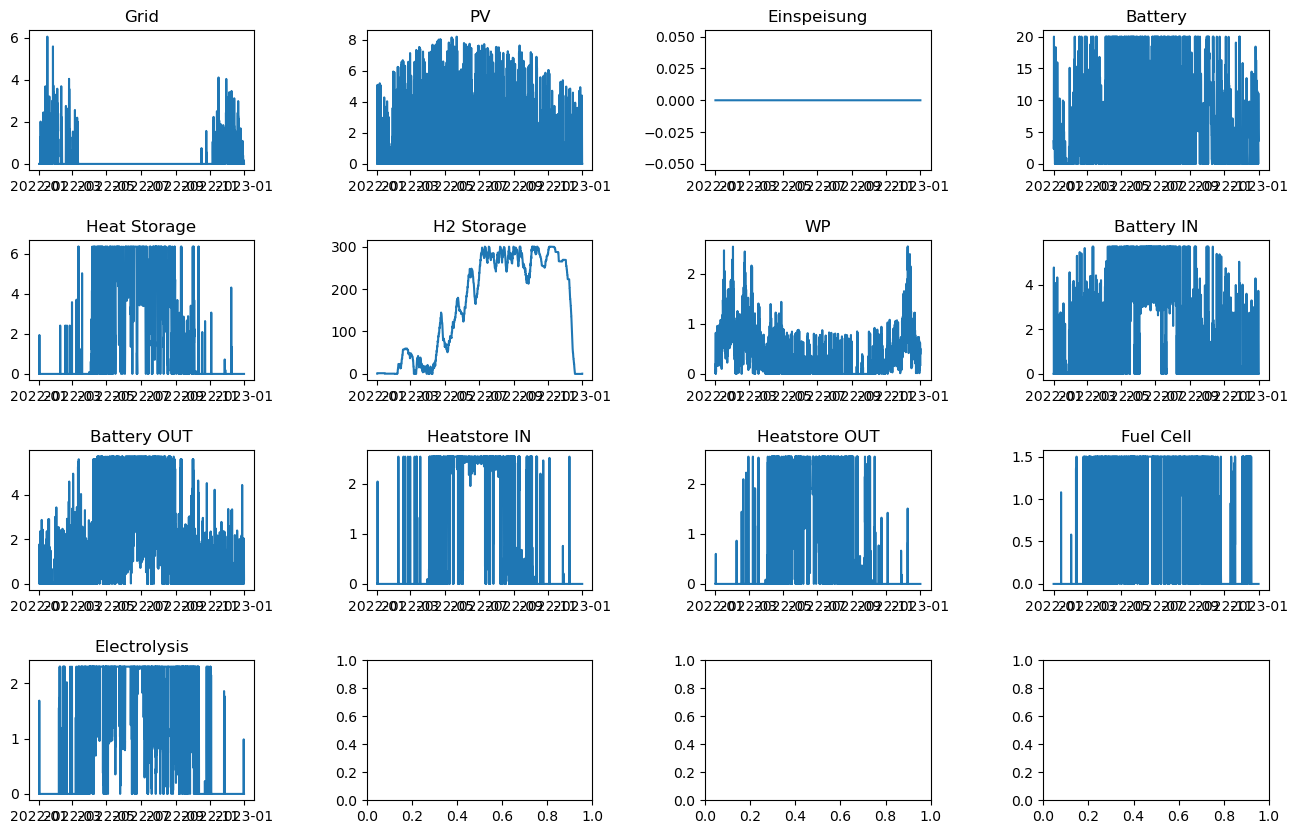

In [15]:
plot_series_data(h2_series)

In [16]:
grid_supply_ref = n_ref.generators_t.p.grid.sum()
grid_supply_h2 = n_h2.generators_t.p.grid.sum()

energy_demand = df_data['electric_load'].sum() + df_data['heat_load'].sum()

autarkie_ref = (energy_demand  - grid_supply_ref) / energy_demand
autarkie_h2 = (energy_demand - grid_supply_h2) / energy_demand

print("grid supply reference:", grid_supply_ref)
print("grid supply h2:", grid_supply_h2)

print("autarkie_ref:", autarkie_ref)
print("autarkie_h2:", autarkie_h2)

grid supply reference: 3949.5050118781896
grid supply h2: 1393.7155843652113
autarkie_ref: 0.7031436471912027
autarkie_h2: 0.8952442587151733


In [17]:
#co2
'''
#n_ref = build_ref_network()

n_ref.global_constraints.loc['co2-limit', 'constant'] = np.inf #höchste CO2 Emissionen setzen
n_ref.optimize(solver_name='gurobi')

#n_h2 = build_h2_network()
#n_ref.optimize(solver_name='gurobi')

results_ref = auswertungsfunktion(n_ref,100,0)
basis_co2_emissions = results_ref['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen


#results_ref = pd.DataFrame(auswertungsfunktion(n_ref,100,0))
#basis_co2_emissions = results_ref['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen

for co2_limit in np.flip(np.arange(0.7, 1, 0.10)):
    print(co2_limit* basis_co2_emissions)
    n_ref.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)
    n_ref.optimize(solver_name='gurobi')
    results_ref = results_ref.append(auswertungsfunktion(n_ref, co2_limit * 100))
    '''

"\n#n_ref = build_ref_network()\n\nn_ref.global_constraints.loc['co2-limit', 'constant'] = np.inf #höchste CO2 Emissionen setzen\nn_ref.optimize(solver_name='gurobi')\n\n#n_h2 = build_h2_network()\n#n_ref.optimize(solver_name='gurobi')\n\nresults_ref = auswertungsfunktion(n_ref,100,0)\nbasis_co2_emissions = results_ref['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen\n\n\n#results_ref = pd.DataFrame(auswertungsfunktion(n_ref,100,0))\n#basis_co2_emissions = results_ref['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen\n\nfor co2_limit in np.flip(np.arange(0.7, 1, 0.10)):\n    print(co2_limit* basis_co2_emissions)\n    n_ref.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)\n    n_ref.optimize(solver_name='gurobi')\n    results_ref = results_ref.append(auswertungsfunktion(n_ref, co2_limit * 100))\n    "

In [18]:
#co2
'''

n_h2.global_constraints.loc['co2-limit', 'constant'] = np.inf #höchste CO2 Emissionen setzen

#Iterationen
#n_ref = build_ref_network()
#n_h2 = build_h2_network()
n_h2.optimize(solver_name='gurobi')
#results_ref = pd.DataFrame()
#results_h2 = pd.DataFrame()
results_h2 = pd.DataFrame(auswertungsfunktion(n_h2,100,0))
basis_co2_emissions = results_h2['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen


for co2_limit in np.flip(np.arange(0.7, 1, 0.10)):
    print(co2_limit* basis_co2_emissions)
    n_h2.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)
    n_h2.optimize(solver_name='gurobi')
    results_h2 = results_h2.append(auswertungsfunktion(n_h2, co2_limit * 100))
    

for strompreis_bezug in np.flip(np.arange(0.28, 1.48, 0.4)): 
    print(strompreis_bezug)
    n_ref.generators.loc['grid', 'marginal_cost'] = strompreis_bezug
    n_h2.generators.loc['grid', 'marginal_cost'] = strompreis_bezug
    n_ref.optimize(solver_name = 'gurobi')
    n_h2.optimize(solver_name='gurobi')
    n_h2.stores.loc['battery', 'e_nom'] = n_ref.stores.e_nom_opt.battery
    n_h2.stores.loc['heat_storage', 'e_nom'] = n_ref.stores.e_nom_opt.heat_storage
    
    results_h2 = results_h2.append(auswertungsfunktion(n_h2, strompreis_bezug))
    results_ref = results_ref.append(auswertungsfunktion(n_ref, strompreis_bezug))

'''

"\n\nn_h2.global_constraints.loc['co2-limit', 'constant'] = np.inf #höchste CO2 Emissionen setzen\n\n#Iterationen\n#n_ref = build_ref_network()\n#n_h2 = build_h2_network()\nn_h2.optimize(solver_name='gurobi')\n#results_ref = pd.DataFrame()\n#results_h2 = pd.DataFrame()\nresults_h2 = pd.DataFrame(auswertungsfunktion(n_h2,100,0))\nbasis_co2_emissions = results_h2['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen\n\n\nfor co2_limit in np.flip(np.arange(0.7, 1, 0.10)):\n    print(co2_limit* basis_co2_emissions)\n    n_h2.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)\n    n_h2.optimize(solver_name='gurobi')\n    results_h2 = results_h2.append(auswertungsfunktion(n_h2, co2_limit * 100))\n    \n\nfor strompreis_bezug in np.flip(np.arange(0.28, 1.48, 0.4)): \n    print(strompreis_bezug)\n    n_ref.generators.loc['grid', 'marginal_cost'] = strompreis_bezug\n    n_h2.generators.loc['grid', 'marg

In [19]:
#Test mit statischem Preis (1) und Preisprofil (2)
# setup reference networks
n_ref1 = build_ref_network()

n_ref2 = build_ref_network()
n_ref2.generators_t.marginal_cost.grid = df_price_data["2021"]
# optimize
n_ref1.optimize(solver_name='gurobi')
n_ref2.optimize(solver_name='gurobi')

# setup h2 networks
n_hy1 = build_h2_network()
#n_hy1.stores.e_nom.battery = n_ref1.stores.e_nom_opt.battery
n_hy1.stores.e_nom.heat_storage = n_ref1.stores.e_nom_opt.heat_storage
n_hy1.links.p_nom.wp = n_ref1.links.p_nom_opt.wp

n_hy2 = build_h2_network()
#n_hy2.stores.e_nom.battery = n_ref2.stores.e_nom_opt.battery
n_hy2.stores.e_nom.heat_storage = n_ref2.stores.e_nom_opt.heat_storage
n_hy2.links.p_nom.wp = n_ref2.links.p_nom_opt.wp
n_hy2.links.p_nom_max.charge_heat = n_ref2.links.p_nom_opt.wp
n_hy2.links.p_nom_max.discharge_heat = n_ref2.links.p_nom_opt.wp
n_hy2.generators_t.marginal_cost.grid = df_price_data["2021"]
#n_hy2.links_t.p_max_pu.ely = df_season["ely"]
#n_hy2.links_t.p_max_pu.fc = df_season["fc"]

# optimize networks
n_hy1.optimize(solver_name='gurobi')
n_hy2.optimize(solver_name='gurobi')

ref1_data = opt_series_summary(n_ref1, h2=False)
ref2_data = opt_series_summary(n_ref2, h2=False)
hy1_data = opt_series_summary(n_hy1, h2=True)
hy2_data = opt_series_summary(n_hy2, h2=True)

C:\Users\Marvin\AppData\Local\Temp\ipykernel_27344\2256583393.py:6: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access

{'bat_bus'}
{'bat_bus'}
INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 48.77it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-ko4n07x5.lp
Reading time = 0.24 seconds
obj: 157689 rows, 70086 columns, 297848 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 157689 rows, 70086 columns and 297848 nonzeros
Model fingerprint: 0x9fb7bb68
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [8e-02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120032 rows and 29810 columns
Presolve time: 0.09s
Presolved: 37657 rows, 40276 columns, 104211 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

B

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70086 primals, 157689 duals
Objective: 4.66e+03
Solver model: available
Solver message: 2

{'bat_bus'}
{'bat_bus'}
INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 48.10it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-q4h1ufqv.lp
Reading time = 0.24 seconds
obj: 157689 rows, 70086 columns, 297848 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 157689 rows, 70086 columns and 297848 nonzeros
Model fingerprint: 0x9fb7bb68
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [8e-02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120032 rows and 29810 columns
Presolve time: 0.09s
Presolved: 37657 rows, 40276 columns, 104211 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

B

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70086 primals, 157689 duals
Objective: 4.66e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_27344\2256583393.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Marvin\AppData\Local\Temp\ipykernel_27344\2256583393.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Marvin\AppData\Local\Temp\ipykernel_27344\2256583393.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-t315fbew.lp
Reading time = 0.48 seconds
obj: 297848 rows, 140165 columns, 551887 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297848 rows, 140165 columns and 551887 nonzeros
Model fingerprint: 0x13e6598a
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [5e-02, 1e+100]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245288 rows and 30703 columns
Presolve time: 0.20s
Presolved: 52560 rows, 109462 columns, 232101 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140165 primals, 297848 duals
Objective: 1.19e+05
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 25.28it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-ur6uazg2.lp
Reading time = 0.47 seconds
obj: 297848 rows, 140165 columns, 551887 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297848 rows, 140165 columns and 551887 nonzeros
Model fingerprint: 0xf715ef13
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [5e-02, 1e+100]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245666 rows and 31081 columns
Presolve time: 0.19s
Presolved: 52182 rows, 109084 columns, 230589 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140165 primals, 297848 duals
Objective: 1.19e+05
Solver model: available
Solver message: 2



CO2-Emissionen:  1714.0851751551343
CO2-Emissionen:  1714.0851751551343
CO2-Emissionen:  604.6070617360018
CO2-Emissionen:  604.8725636145017


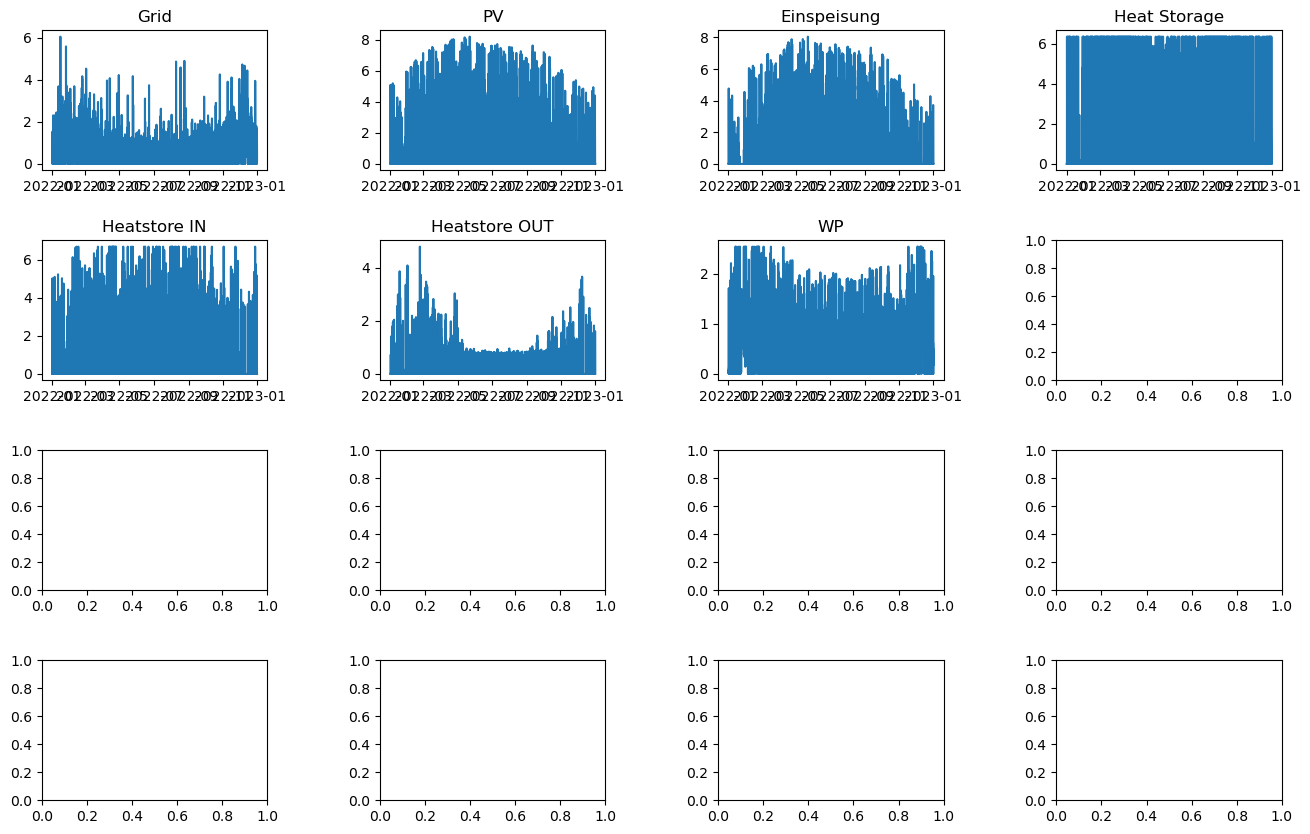

In [20]:
plot_series_data(ref1_data)

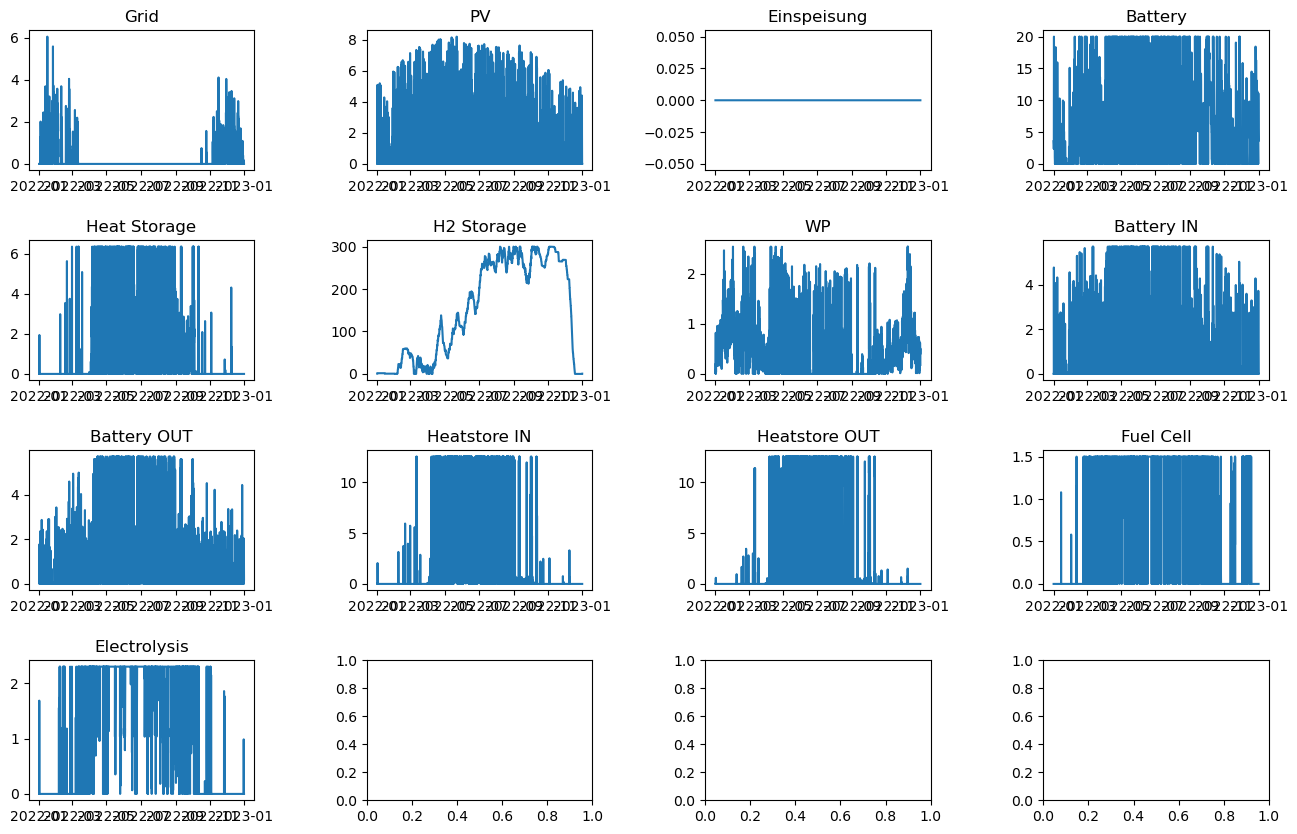

In [21]:
plot_series_data(hy1_data)

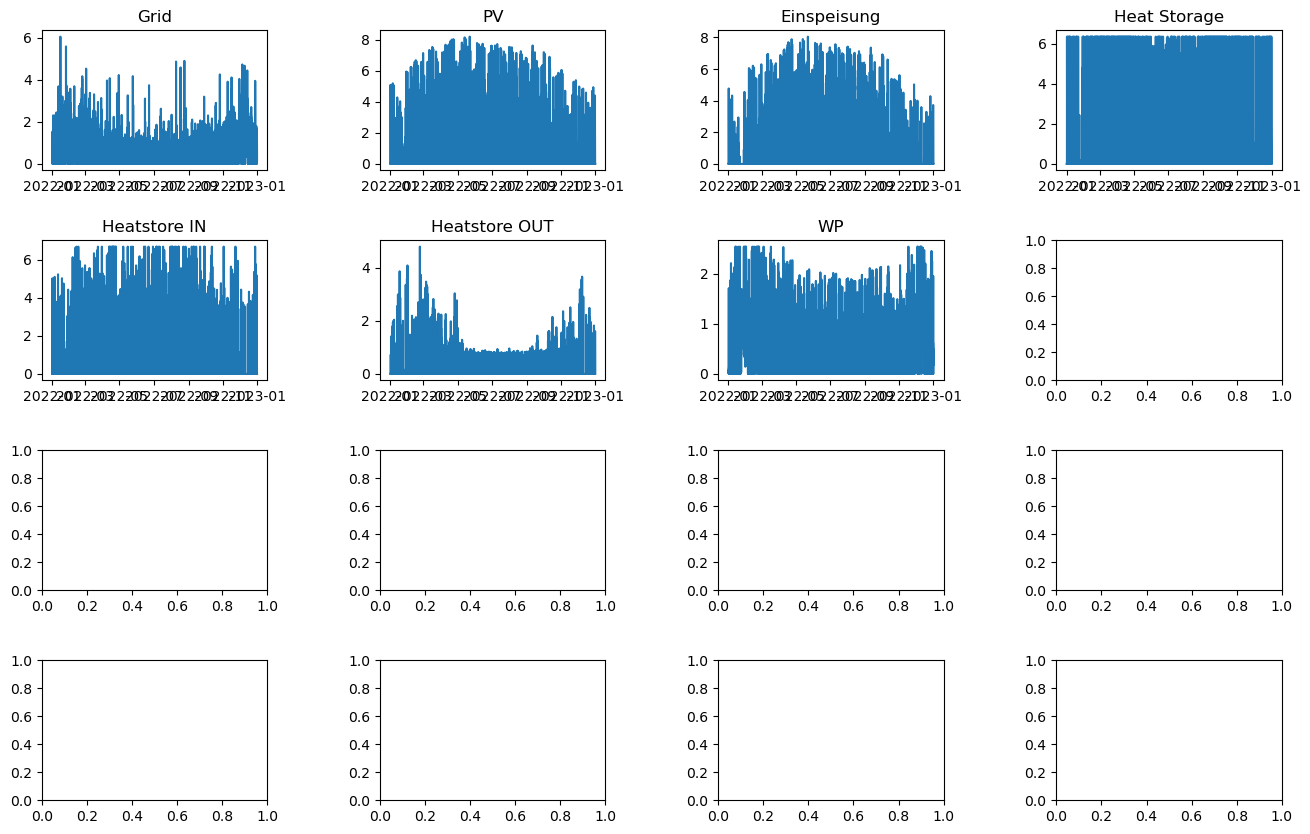

In [22]:
plot_series_data(ref2_data)

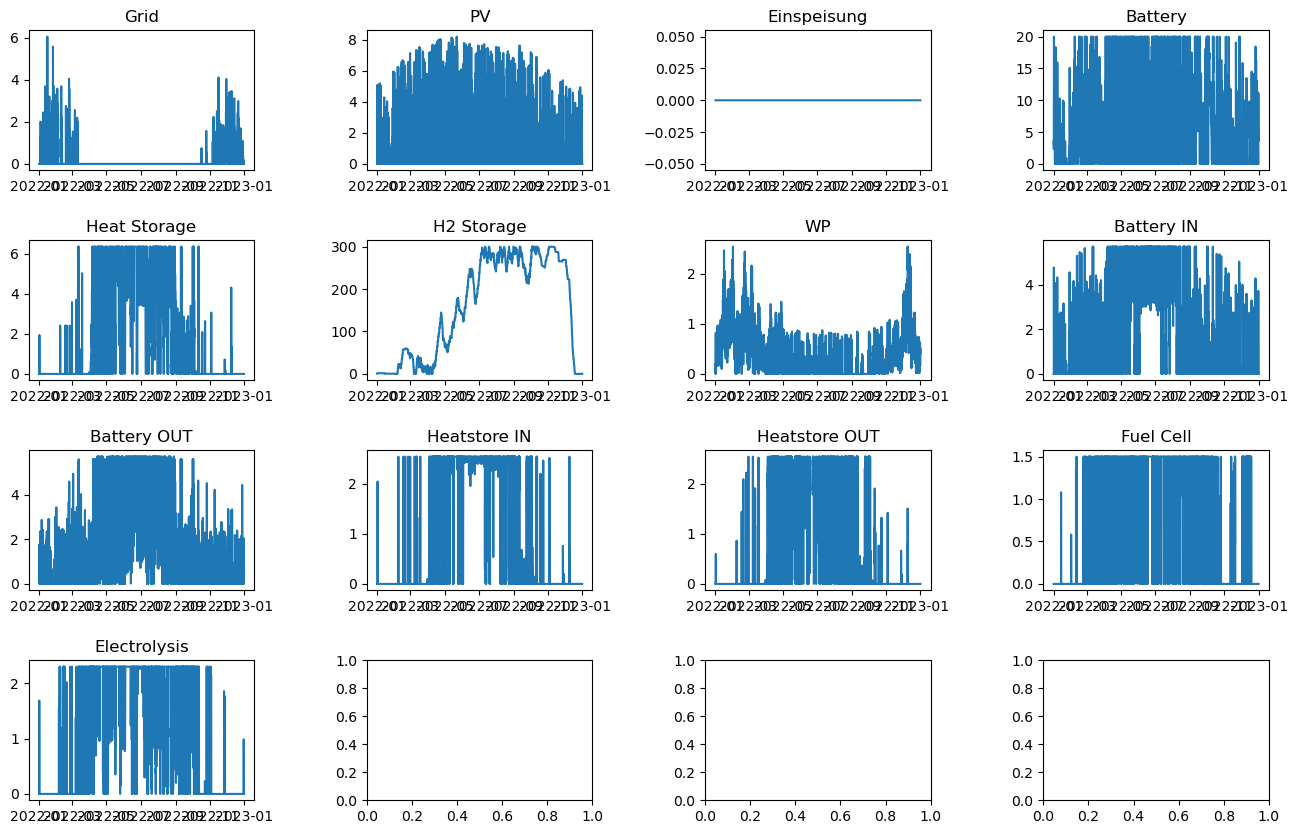

In [23]:
plot_series_data(hy2_data)